In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import jaxley as jx
from jax import jit, vmap, value_and_grad
import jaxley.optimize.transforms as jt
from jax.flatten_util import ravel_pytree

import optax

import numpy as np
_ = np.random.seed(0)

from train_utils import simulate, init_opt, predict, accuracy, ce
from reaching_task import Reaching
from jaxley_rnn import build_rnn

import matplotlib.pyplot as plt
%matplotlib inline


### Here we have an example of training more realistic neuroscience RNNs

Here units in the network are guided by [Hodkin Huxley equations](https://neuronaldynamics.epfl.ch/online/Ch2.S2.html)

These equations need to be integrated with very small time-steps (e.g., 0.025 ms), whereas we are interested in training models on tasks of about a second of duration. Integrating highly non-linear network for 1000/0.025 timesteps can quickly lead to vanishing and exploding gradients.

We use our [Jaxley](https://github.com/jaxleyverse/jaxley) toolbox for implementing the models. See the [Preprint](https://www.biorxiv.org/content/10.1101/2024.08.21.608979v2) (soon to be out in Nature Methods) for more details.

### We use the same task as before (but with one-hot encoding)
The stimulus position on the ring is defined by one hot encoding

The model has number of input channels equal to potential stimuli plus 1 (fixation / response cue). It receives the stimulus identity one-hot encoded during stimulus onset. During the Movement onset the model gets a constant input cue to the last input channels, and it is tasked to output the stored location.


![Monkey reach task](https://raw.githubusercontent.com/mackelab/pyrnn/main/tutorials/images/MonkeyReach.png)

image adapted from [Gallego et al. 2018](https://www.biorxiv.org/content/10.1101/447441v1.full)

In [2]:
dt = .025 # integration time step in ms

# ideally we would like something like:
trial_len = 1200 # time in ms
onset = [100,200]
stim_dur = [150,200]
delay_dur = [400,600]

# but to keep things fast for this example, we use shorter trials:
trial_len = 20
onset = [5,6]
stim_dur = [10,11]
delay_dur = [1,2]

n_classes = 6
batch_size = 64

task_params={
        'trial_len' : int(trial_len / dt),          # total trial length in steps
        'onset'     : (int(onset[0] / dt), int(onset[1] / dt)),    # stimulus onset range in steps
        'stim_dur'  : (int(stim_dur[0] / dt), int(stim_dur[1] / dt)),  # stimulus duration range in steps
        'delay_dur' : (int(delay_dur[0] / dt), int(delay_dur[1] / dt)), # delay duration range in steps
        'n_stim'    : n_classes,                       # number of unique stimuli
        'batch_size': batch_size                    # batch size for get_batch
}
task = Reaching(task_params=task_params,
)

### Next we define an RNN
The model is similar to those in Fig 4. of our [Preprint](https://www.biorxiv.org/content/10.1101/2024.08.21.608979v2). 
You can probably leave the parameters as is.

56 [56, 57] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
15.333333333333334
828
54
conn probability recurrence: 0.2839506172839506
EIratio:4.4
Normaliser: 0.5267085409714959
Spectral radius recurrence: 0.0007991130800482155
Expected gain: 0.0005654866776461627


Text(0.5, 1.0, 'Recurrent weight matrix')

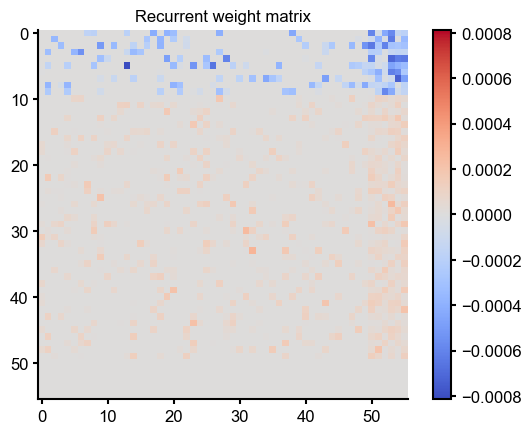

In [3]:
seed = 1
n_rec_units = 50 # relatively small so training is fast


g_scaling = 100_000 / 2 / np.pi / 10.0 / 1.0
# Initial RNN params
RNN_params = {
    "RNN_seed":seed,
    "seed":seed,
    "n_rec":n_rec_units,
    "n_inh":int(0.2*n_rec_units),
    "n_out":n_classes,
    "init_gain": .9/g_scaling,
    "out_scale":.2,
    "inp_scale":.5,
    "in_conn_prob":.1,
    "out_conn_prob":1,
    "rec_conn_prob":.05,
    "k_minus":1,
    "out_k_minus":.1,
    "n_stim":n_classes,
}

net, conn_matrix,input_weights,input_weights_mask = build_rnn(RNN_params,verbose=False)

plt.figure()
vlim = jnp.max(jnp.abs(conn_matrix))
im = plt.imshow(conn_matrix, cmap ='coolwarm', vmin=-vlim, vmax=vlim)
plt.colorbar(im)
plt.title("Recurrent weight matrix")

### Example simulation

Text(0, 0.5, 'Units')

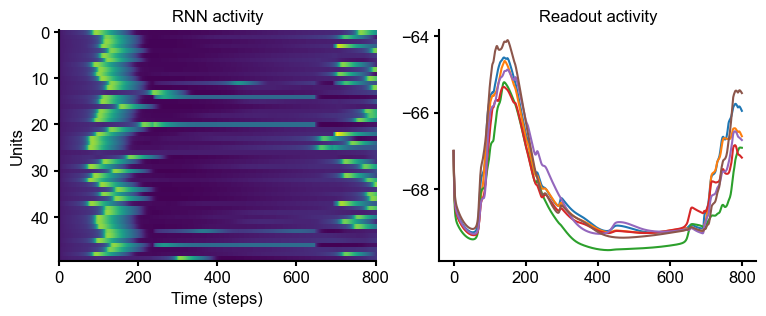

In [ ]:
net.delete_recordings()
for i in range(RNN_params['n_rec']+RNN_params['n_out']):
    net.cell(i).branch(0).comp(0).record(verbose=False)

stim, target, mask = task.get_batch()
fig,ax = plt.subplots(1,2,figsize=(9,3))
i = np.random.randint(0,stim.shape[0])
params = input_weights
v= simulate(params, stim[i],input_weights_mask,net,dt=dt,levels=3)
ax[0].imshow(v[:RNN_params['n_rec']],aspect='auto')
ax[1].plot(v[RNN_params['n_rec']:].T)
ax[0].set_title('RNN activity')
ax[1].set_title('Readout activity')
ax[1].spines[['top','right']].set_visible(False)

ax[0].set_xlabel('Time (steps)')
ax[0].set_ylabel('Units')


### Parameter constraints
Since some parameters represent physical units, and might e.g., have a positivity constraint, we transform the parameters with sigmoids and softplus during training, such that they satisfy these constraints.

In [5]:
#constraints
lowers = {"input_weights": 0, "IonotropicSynapse_gS": 0, "IonotropicSynapse_k_minus": 1/20, "v": -120.0}
uppers= {"input_weights": 4, "IonotropicSynapse_gS": None, "IonotropicSynapse_k_minus": 2.0, "v":0}

input_weights_min = lowers['input_weights']
input_weights_max = uppers['input_weights']
IonotropicSynapse_k_minus_min = lowers['IonotropicSynapse_k_minus']
IonotropicSynapse_k_minus_max = uppers['IonotropicSynapse_k_minus']


In [6]:
tf = jx.ParamTransform([{"input_weights": jt.SigmoidTransform(input_weights_min, input_weights_max)},
                        {"IonotropicSynapse_gS": jt.SoftplusTransform(0)},
                        {"IonotropicSynapse_k_minus" : jt.SigmoidTransform(IonotropicSynapse_k_minus_min, IonotropicSynapse_k_minus_max)}])

### Now we can start to setup training

In [7]:
JIT =False # set to True to enable JIT compilation (faster, but harder to debug)

training_params={
    "lr":0.01,
    "lr_end":0.0001,
    "max_epochs":150,
}

In [9]:
# make network trainable and get parameters
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
net.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_k_minus")
params = net.get_parameters()
params = input_weights + params

# push through transform for constraints
opt_params = tf.inverse(params)
net.delete_recordings()

# record from readouts to get model predictions
for i in range(RNN_params['n_out']):
    net.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)


Number of newly added trainable parameters: 828. Total number of trainable parameters: 1656
Number of newly added trainable parameters: 828. Total number of trainable parameters: 2484


ValueError: List arity mismatch: 3 != 4; list: [{'input_weights': <jaxley.optimize.transforms.SigmoidTransform object at 0x3099c0b90>}, {'IonotropicSynapse_gS': <jaxley.optimize.transforms.SoftplusTransform object at 0x30993b510>}, {'IonotropicSynapse_k_minus': <jaxley.optimize.transforms.SigmoidTransform object at 0x309a43150>}].

In [ ]:
# define the loss function

def loss_fn(opt_params, stim, label, mask):
    """Compute loss and accuracy for optimization.
    Args:
        opt_params: parameters in the transformed space
        stim:  (T-1, n_classes+1)
        label: (T, n_classses)
        mask:  (T, 1)
    """
    params = tf.forward(opt_params)
    pred = predict(params, stim, input_weights_mask,net, dt=dt, levels=1)
    loss_val = ce(pred, label, mask)
    acc_val = accuracy(pred, label, mask)
    return loss_val, acc_val

vmapped_loss_fn = vmap(loss_fn, in_axes=(None, 0, 0, 0))

def batched_loss_fn(params, stims, labels, masks):
    """mean loss over batch of trials"""
    all_loss_vals,all_accs = vmapped_loss_fn(params, stims, labels, masks)
    return jnp.mean(all_loss_vals),jnp.mean(all_accs)


if JIT:
    grad_fn = jit(value_and_grad(batched_loss_fn, argnums=0, has_aux=True))
else:
    grad_fn = (value_and_grad(batched_loss_fn, argnums=0, has_aux=True))

In [ ]:
# Run training

opt_state, optimizer = init_opt(opt_params, lr = training_params['lr'], lr_end=training_params['lr_end'])

for i in range(training_params['max_epochs']):
    stim, target, mask = task.get_batch()
    (l,a), g = grad_fn(opt_params, stim[:,1:], target, mask)
    flat_g, _ = ravel_pytree(g)
    print("Global grad norm:", jnp.linalg.norm(flat_g))
    if i % 1 == 0:
        print(f"it {i}, loss {l}, acc {a}")
        
    if np.isnan(l):
        print("loss is nan")
        break

    updates, opt_state = optimizer.update(g, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)



Global grad norm: 0.21162008835560614
it 0, loss 1.1567377868379096, acc 0.12843334674835205
Global grad norm: 0.19492629615291135
it 1, loss 1.1221732327404212, acc 0.14514610171318054
Global grad norm: 0.16729707358455614
it 2, loss 1.075933421130859, acc 0.1435784101486206
Global grad norm: 0.15413240988232915
it 3, loss 1.0929495180609048, acc 0.15281683206558228
Global grad norm: 0.15904574045619763
it 4, loss 1.0596539099247213, acc 0.20799845457077026
Global grad norm: 0.2496262960985731
it 5, loss 1.0410978438239022, acc 0.2641092538833618
Global grad norm: 0.1483792709392002
it 6, loss 1.0278323378401104, acc 0.22702103853225708
Global grad norm: 0.17105130742767816
it 7, loss 1.027476115748107, acc 0.24467813968658447
Global grad norm: 0.16769713808359354
it 8, loss 1.0478276085417537, acc 0.20663772523403168
Global grad norm: 0.19325518763711977
it 9, loss 0.934184942846468, acc 0.32768794894218445
Global grad norm: 0.17820547310382479
it 10, loss 1.021161749104551, acc 0.22


KeyboardInterrupt



KeyboardInterrupt: 

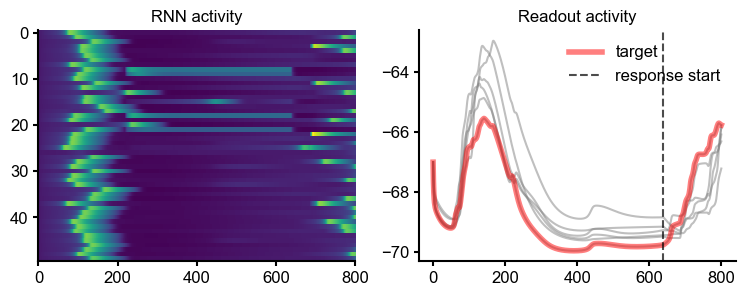

In [ ]:
# visualize trained network
net.delete_recordings()
for i in range(RNN_params['n_rec']+RNN_params['n_out']):
    net.cell(i).branch(0).comp(0).record(verbose=False)

stim, target, mask = task.get_batch()
fig,ax = plt.subplots(1,2,figsize=(9,3))
i = np.random.randint(0,stim.shape[0])
params = tf.forward(opt_params)
v= simulate(params, stim[i],input_weights_mask,net,dt=dt,levels=1)
ax[0].imshow(v[:RNN_params['n_rec']],aspect='auto')
ax[1].plot(v[RNN_params['n_rec']:].T,color='gray',alpha=0.5)


# color the target readout, this should have the highest activity
target = np.argmax(np.sum(stim[i,:,:n_classes],axis=0))
ax[1].plot(v[RNN_params['n_rec']+target].T,linewidth=4, color='red', alpha=0.5,label='target')
response_start = np.sum(mask[i,:, 0]==0)
ax[1].axvline(response_start, color='black', linestyle='--', alpha=0.7, label='response start')
ax[0].set_title('RNN activity')
ax[1].set_title('Readout activity')
ax[1].legend()
ax[0].set_xlabel('Time (steps)')
ax[0].set_ylabel('Units')
ax[1].spines[['top','right']].set_visible(False)
